In [198]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [199]:
df = pd.read_csv('./data/nuclear_overview_after_eda.csv', parse_dates=['Date']) # parse_dates convert column to datetime index
df.head()

,Date,Year,Month,"Nuclear Generating Units, Net Summer Capacity",Nuclear Electricity Net Generation,Nuclear Share of Electricity Net Generation,"Nuclear Generating Units, Capacity Factor"
0,1973-01-01,1973,January,14.533,6246,3.9,57.8
1,1973-02-01,1973,February,14.533,5928,4.1,60.7
2,1973-03-01,1973,March,15.314,6649,4.5,58.4
3,1973-04-01,1973,April,15.314,5876,4.2,53.4
4,1973-05-01,1973,May,16.174,5697,3.9,47.3


In [200]:
df.columns

Index(['Date', 'Year', 'Month',
       'Nuclear Generating Units, Net Summer Capacity',
       'Nuclear Electricity Net Generation',
       'Nuclear Share of Electricity Net Generation',
       'Nuclear Generating Units, Capacity Factor'],
      dtype='object')

In [201]:
# data preprocessing
df_daily = df.set_index('Date').resample('D').asfreq()
df_daily.drop(columns=['Nuclear Generating Units, Net Summer Capacity', 'Nuclear Share of Electricity Net Generation', 'Nuclear Generating Units, Capacity Factor'], inplace=True)
df_daily[['Nuclear Electricity Net Generation']] = df_daily[['Nuclear Electricity Net Generation']].interpolate(method='linear')
df_daily.rename(columns={'Nuclear Electricity Net Generation': 'y_true'}, inplace=True)
df_daily.reset_index(inplace=True)
df_daily['Year'] = df_daily['Date'].dt.year
df_daily['Month'] = df_daily['Date'].dt.month
df_daily.insert(df_daily.columns.get_loc('Month') + 1, 'DayOfWeek', df_daily['Date'].dt.dayofweek)
df_daily.insert(df_daily.columns.get_loc('Month') + 2, 'DayOfYear', df_daily['Date'].dt.dayofweek)
df_daily.insert(df_daily.columns.get_loc('Month'), 'Quarter', df_daily['Date'].dt.quarter)
df_daily.head(10)

,Date,Year,Quarter,Month,DayOfWeek,DayOfYear,y_true
0,1973-01-01,1973,1,1,0,0,6246.000000
1,1973-01-02,1973,1,1,1,1,6235.741935
2,1973-01-03,1973,1,1,2,2,6225.483871
3,1973-01-04,1973,1,1,3,3,6215.225806
4,1973-01-05,1973,1,1,4,4,6204.967742
5,1973-01-06,1973,1,1,5,5,6194.709677
6,1973-01-07,1973,1,1,6,6,6184.451613
7,1973-01-08,1973,1,1,0,0,6174.193548
8,1973-01-09,1973,1,1,1,1,6163.935484
9,1973-01-10,1973,1,1,2,2,6153.677419


<Axes: xlabel='Date', ylabel='y_true'>

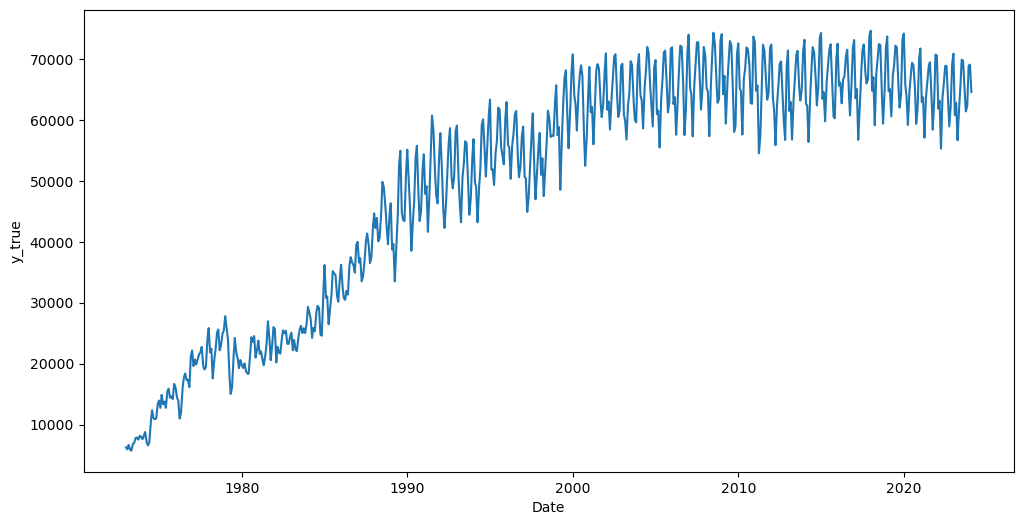

In [202]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_daily, x='Date', y='y_true')

In [203]:
df_daily['lag_7'] = df_daily['y_true'].shift(7)
df_daily['rolling_mean_1']  = df_daily['y_true'].shift(1).rolling(window=1).mean()
df_daily['rolling_std_1']   = df_daily['y_true'].shift(1).rolling(window=1).std()
df_daily['rolling_mean_7']  = df_daily['y_true'].shift(1).rolling(window=7).mean()
df_daily['rolling_std_7']   = df_daily['y_true'].shift(1).rolling(window=7).std()
df_daily['rolling_mean_30'] = df_daily['y_true'].shift(1).rolling(window=30).mean()
df_daily['rolling_std_30']  = df_daily['y_true'].shift(1).rolling(window=30).std()
df_daily.head(50)

,Date,Year,Quarter,Month,DayOfWeek,DayOfYear,y_true,lag_7,rolling_mean_1,rolling_std_1,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30
0,1973-01-01,1973,1,1,0,0,6246.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1973-01-02,1973,1,1,1,1,6235.741935,NaN,6246.000000,NaN,NaN,NaN,NaN,NaN
2,1973-01-03,1973,1,1,2,2,6225.483871,NaN,6235.741935,NaN,NaN,NaN,NaN,NaN
3,1973-01-04,1973,1,1,3,3,6215.225806,NaN,6225.483871,NaN,NaN,NaN,NaN,NaN
4,1973-01-05,1973,1,1,4,4,6204.967742,NaN,6215.225806,NaN,NaN,NaN,NaN,NaN
5,1973-01-06,1973,1,1,5,5,6194.709677,NaN,6204.967742,NaN,NaN,NaN,NaN,NaN
6,1973-01-07,1973,1,1,6,6,6184.451613,NaN,6194.709677,NaN,NaN,NaN,NaN,NaN
7,1973-01-08,1973,1,1,0,0,6174.193548,6246.000000,6184.451613,NaN,6215.225806,22.159952,NaN,NaN
8,1973-01-09,1973,1,1,1,1,6163.935484,6235.741935,6174.193548,NaN,6204.967742,22.159952,NaN,NaN
9,1973-01-10,1973,1,1,2,2,6153.677419,6225.483871,6163.935484,NaN,6194.709677,22.159952,NaN,NaN


In [204]:
# data leakage check
print(df_daily['y_true'].iloc[0:7].mean()) # print the mean of first 7 days
df_daily[['y_true', 'rolling_mean_7']].head(10) # check the rolling mean values

6215.225806451614


,y_true,rolling_mean_7
0,6246.000000,NaN
1,6235.741935,NaN
2,6225.483871,NaN
3,6215.225806,NaN
4,6204.967742,NaN
5,6194.709677,NaN
6,6184.451613,NaN
7,6174.193548,6215.225806
8,6163.935484,6204.967742
9,6153.677419,6194.709677


In [205]:
# Fit the scaler on your y data
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(df_daily[['y_true']])
df_daily['y_scaled'] = y_scaled

## Time Series Data Split

In [206]:
df_daily.columns

Index(['Date', 'Year', 'Quarter', 'Month', 'DayOfWeek', 'DayOfYear', 'y_true',
       'lag_7', 'rolling_mean_1', 'rolling_std_1', 'rolling_mean_7',
       'rolling_std_7', 'rolling_mean_30', 'rolling_std_30', 'y_scaled'],
      dtype='object')

In [207]:
# cross validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

X = df_daily[['Year', 'Quarter', 'Month', 'DayOfWeek', 'DayOfYear', 'lag_7',
       'rolling_mean_1', 'rolling_std_1', 'rolling_mean_7', 'rolling_std_7',
       'rolling_mean_30', 'rolling_std_30']] #  excluded

y = df_daily['y_scaled'] # 'y_true'

## Model Training

XGBoost model is used for the training and GridSearchCV is used for the hyperparameter tuning 

In [208]:
model = xgb.XGBRegressor(objective='reg:squarederror')
param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [1, 0.1, 0.01, 0.001],
    'n_estimators': [500, 1000, 2000, 3000, 5000],
}

grid = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(X, y)

best_model = grid.best_estimator_ # choose the best model from grid search
print(grid.best_params_)
print(f'best RMSE:{np.sqrt(-grid.best_score_)}')

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 2000}
best RMSE:0.4736345897254434


In [209]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    best_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test), (X_train, y_train)],
              verbose=250)
    y_test_preds = best_model.predict(X_test)
    y_train_preds = best_model.predict(X_train)

df_test_pred  = pd.DataFrame({'y_test_true': y_test, 'y_test_pred': y_test_preds})
df_train_pred = pd.DataFrame({'y_train_true': y_train, 'y_train_pred': y_train_preds})


[0]	validation_0-rmse:1.50169	validation_1-rmse:0.34654


[250]	validation_0-rmse:0.92348	validation_1-rmse:0.04081
[500]	validation_0-rmse:0.81366	validation_1-rmse:0.00741
[750]	validation_0-rmse:0.78831	validation_1-rmse:0.00440
[1000]	validation_0-rmse:0.78370	validation_1-rmse:0.00382
[1250]	validation_0-rmse:0.78120	validation_1-rmse:0.00352
[1500]	validation_0-rmse:0.78039	validation_1-rmse:0.00335
[1750]	validation_0-rmse:0.78010	validation_1-rmse:0.00325
[1999]	validation_0-rmse:0.78049	validation_1-rmse:0.00318
[0]	validation_0-rmse:1.57703	validation_1-rmse:0.81042
[250]	validation_0-rmse:0.49057	validation_1-rmse:0.08733
[500]	validation_0-rmse:0.30610	validation_1-rmse:0.01394
[750]	validation_0-rmse:0.26439	validation_1-rmse:0.00709
[1000]	validation_0-rmse:0.25750	validation_1-rmse:0.00587
[1250]	validation_0-rmse:0.25509	validation_1-rmse:0.00539
[1500]	validation_0-rmse:0.25403	validation_1-rmse:0.00512
[1750]	validation_0-rmse:0.25309	validation_1-rmse:0.00494
[1999]	validation_0-rmse:0.25257	validation_1-rmse:0.00482
[0]	va

In [210]:
df_test_pred['Date'] = df_daily['Date'].iloc[-len(df_test_pred):].values
df_test_pred['y_test_true'] = scaler_y.inverse_transform(df_test_pred[['y_test_true']])
df_test_pred['y_test_pred'] = scaler_y.inverse_transform(df_test_pred[['y_test_pred']])
df_test_pred

,y_test_true,y_test_pred,Date
13995,56684.200000,56659.546875,2011-04-27
13996,56766.400000,56913.976562,2011-04-28
13997,56848.600000,56913.976562,2011-04-29
13998,56930.800000,56917.468750,2011-04-30
13999,57013.000000,57182.589844,2011-05-01
...,...,...,...
18654,65164.129032,65175.496094,2024-01-28
18655,65019.096774,64982.378906,2024-01-29
18656,64874.064516,64890.511719,2024-01-30
18657,64729.032258,64738.867188,2024-01-31


In [211]:
df_train_pred['Date'] = df_daily['Date'].iloc[:len(df_train_pred)].values
df_train_pred['y_train_true'] = scaler_y.inverse_transform(df_train_pred[['y_train_true']])
df_train_pred['y_train_pred'] = scaler_y.inverse_transform(df_train_pred[['y_train_pred']])
df_train_pred

,y_train_true,y_train_pred,Date
0,6246.000000,6250.448730,1973-01-01
1,6235.741935,6201.444824,1973-01-02
2,6225.483871,6201.444824,1973-01-03
3,6215.225806,6201.444824,1973-01-04
4,6204.967742,6201.444824,1973-01-05
...,...,...,...
13990,56273.200000,56340.753906,2011-04-22
13991,56355.400000,56338.496094,2011-04-23
13992,56437.600000,56476.089844,2011-04-24
13993,56519.800000,56659.546875,2011-04-25


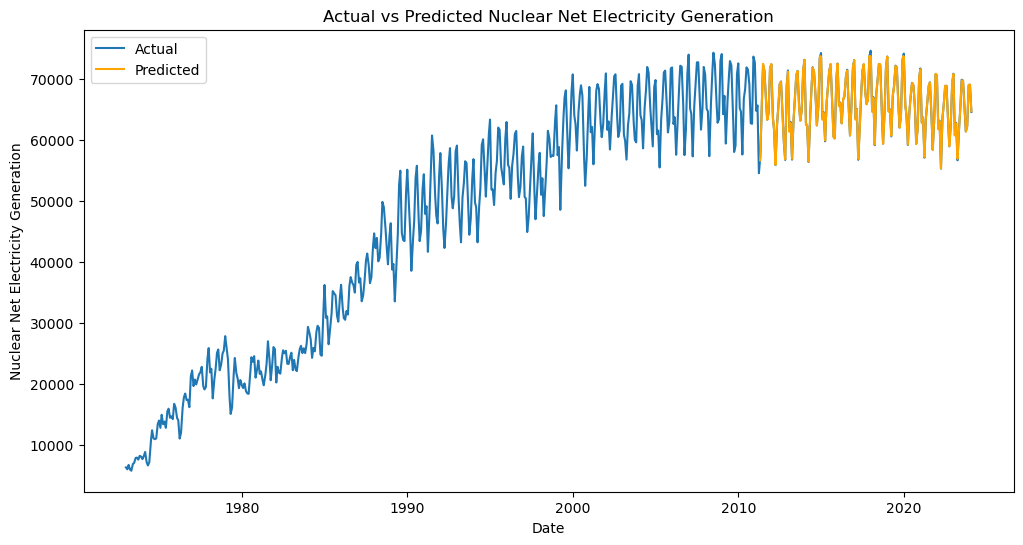

,y_test_true,y_test_pred,Date
13995,56684.200000,56659.546875,2011-04-27
13996,56766.400000,56913.976562,2011-04-28
13997,56848.600000,56913.976562,2011-04-29
13998,56930.800000,56917.468750,2011-04-30
13999,57013.000000,57182.589844,2011-05-01
...,...,...,...
18654,65164.129032,65175.496094,2024-01-28
18655,65019.096774,64982.378906,2024-01-29
18656,64874.064516,64890.511719,2024-01-30
18657,64729.032258,64738.867188,2024-01-31


In [212]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_daily, x='Date', y='y_true', label='Actual')
sns.lineplot(data=df_test_pred, x='Date', y='y_test_pred', color='orange', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Nuclear Net Electricity Generation')
plt.title('Actual vs Predicted Nuclear Net Electricity Generation')
plt.legend()
plt.show()

df_test_pred

<Axes: xlabel='Date', ylabel='y_true'>

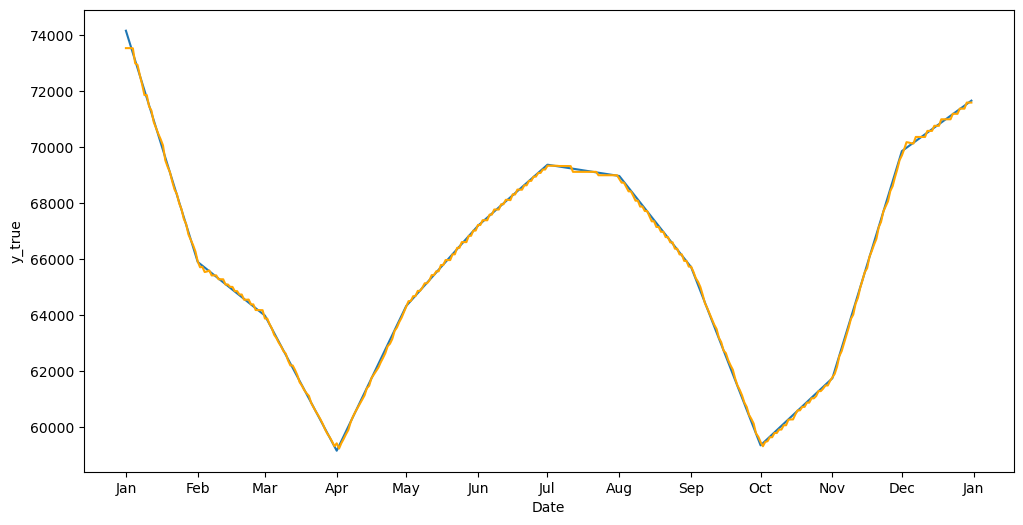

In [213]:
# check for year 2020 data
df_2020 = df_daily[df_daily['Year'] == 2020]
df_2020

plt.figure(figsize=(12,6))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
sns.lineplot(data=df_2020, x='Date', y='y_true')
sns.lineplot(data=df_test_pred[df_test_pred['Date'].dt.year == 2020], x='Date', y='y_test_pred', color='orange')

<Axes: xlabel='Date', ylabel='y_true'>

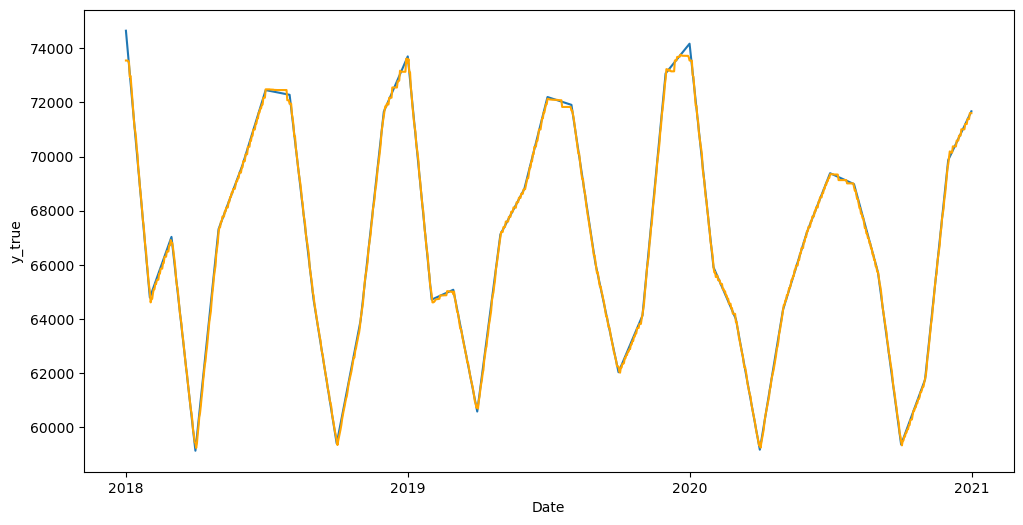

In [214]:
# check for range of year
df_range = df_daily[(df_daily['Year'] <= 2020) & (df_daily['Year'] >= 2018)]
df_range

plt.figure(figsize=(12,6))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
sns.lineplot(data=df_range, x='Date', y='y_true')
sns.lineplot(data=df_test_pred[(df_test_pred['Date'].dt.year <= 2020) & (df_test_pred['Date'].dt.year >= 2018)], x='Date', y='y_test_pred', color='orange')

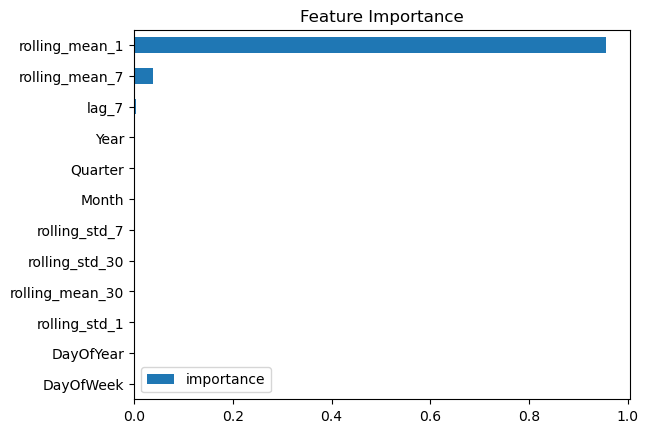

In [215]:
fi = pd.DataFrame(data=best_model.feature_importances_, index=best_model.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [216]:

score_test = np.sqrt(mean_squared_error(df_test_pred['y_test_true'], df_test_pred['y_test_pred']))
print(f'RMSE from the test prediction: {score_test:0.2f}')
score_train = np.sqrt(mean_squared_error(df_train_pred['y_train_true'], df_train_pred['y_train_pred']))
print(f'RMSE from the train prediction: {score_train:0.2f}')

# evaluate overfitting or underfitting
error_tol = 0.1 * score_train 
diff = abs(score_train - score_test)
print('error tolerance:', error_tol)
print('diff:', diff)
if diff < error_tol:
    print("The model generalizes well to unseen data.")
elif score_train > score_test:
    print("The model may be underfitting the training data.")
elif score_train < score_test:
    print("The model may be overfitting the training data.")

RMSE from the test prediction: 108.80
RMSE from the train prediction: 108.19
error tolerance: 10.81941211946799
diff: 0.6098441612242311
The model generalizes well to unseen data.
